In [3]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.anyspell import *
from jetstream_hugo.data import *
import colormaps
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
data_handlers = {}
for varname in ["u", "v", "s"]:
    dh = DataHandler.from_specs("ERA5", "plev", varname, "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=False)
    data_handlers[varname] = dh
data_handler = DataHandler.from_several_dhs(data_handlers)
exp = JetFindingExperiment(data_handler)
ds = exp.ds
all_jets_one_df, all_jets_over_time, flags = exp.track_jets()
props_as_df_uncat = exp.props_as_df(False)
props_as_df = exp.props_as_df(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_df_uncat)
ds = exp.ds
da = exp.ds["s"]
props_as_df = get_nao(props_as_df)
jet_pos_da = jet_position_as_da(all_jets_one_df, exp.path)
props_as_df = get_double_jet_index(props_as_df, jet_pos_da)
props_as_df_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8]))

In [5]:
metric = "euclidean"
nx = 6
ny = 4
exp_s = Experiment(DataHandler.from_specs("ERA5", "plev", "s", "6H", "all", "JJA", -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=True))

ds_center_path = exp_s.path.joinpath(f"som_{nx}_{ny}_pbc_{metric}_center.nc")
if not ds_center_path.is_file():
    ds = exp.ds
    ds = ds.sel(time=ds.time.dt.season=="JJA")
net, centers, labels = exp_s.som_cluster(
    nx,
    ny,
    activation_distance=metric,
    return_type=RAW_REALSPACE,
    force=False,
    sigma=2,
    train_kwargs=dict(num_epochs=20),
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
if not ds_center_path.is_file():
    ds_center = labels_to_centers(labels, ds)
    ds_center.to_netcdf(ds_center_path)
else:
    ds_center = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_s.da.time, "cluster": np.arange(net.n_nodes)})

In [6]:
da_tp = open_da(
    "ERA5", "surf", "tp", "dailymean", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)

In [7]:
da_T = open_da(
    "ERA5", "surf", "t2m", "dailymean", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)

In [8]:
da_sst = open_da(
    "ERA5", "surf", "sst", "dailymean", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)

In [9]:
da_mslp = open_da(
    "ERA5", "surf", "mslp", "dailymean", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)

In [10]:
da_apvs = open_da(
    "ERA5", "thetalev", "apvs", "dailymean", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)

Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]


In [11]:
da_cpvs = open_da(
    "ERA5", "thetalev", "cpvs", "dailymean", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)

Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]


In [12]:
da_z = open_da(
    "ERA5", "plev", "z", "dailymean", "all", "JJA", None, None, None, None, [500], 'dayofyear', {'dayofyear': ('win', 15)}, None,
)

In [13]:
def get_persistent_spell_times_from_som(props_as_df, labels, minlen: int = 4, nt_before: int = 0, nt_after: int = 0, nojune: bool=True):
    labels_df = pl.from_pandas(labels.to_dataframe().reset_index())
    labels_df = labels_df.cast({"time": props_as_df["time"].dtype})
    props_as_df = props_as_df.filter(pl.col("time").is_in(labels_df["time"]))
    index_columns = get_index_columns(props_as_df)
    index = props_as_df[index_columns].unique(maintain_order=True)

    out = labels_df["labels"].rle().struct.unnest()
    out = out.with_columns(start=pl.lit(0).append(pl.col("len").cum_sum().slice(0, pl.col("len").len() - 1)))
    out = out.with_columns(
        range=pl.int_ranges(pl.col("start") - nt_before, pl.col("start") + pl.col("len") + nt_after),
        relative_index=pl.int_ranges(-nt_before, pl.col("len") + nt_after),
    )
    out = out.with_row_index("persistent_spell").explode(["range", "relative_index"])
    out = out.filter(pl.col("range") < len(index), pl.col("range") >= 0)
    out = out.with_columns(index[out["range"]])
    out = out.filter(pl.col("len") >= minlen)
    out = out.with_columns(pl.col("persistent_spell").rle_id())
    out = (
        out.group_by("persistent_spell", maintain_order=True)
            .agg(
                [
                    pl.col(col).filter(
                        pl.col("time").dt.year()
                        == pl.col("time")
                        .dt.year()
                        .get(pl.arg_where(pl.col("relative_index") == 0).first())
                    )
                    for col in ["time", "relative_index"]
                ]
            )
            .explode(["time", "relative_index"])
        )
    if not nojune:
        return out
    june_filter = out.group_by("persistent_spell", maintain_order=True).agg((pl.col("time").dt.month() == 6).sum() > 0.8)["time"]
    out = out.filter(pl.col("persistent_spell").is_in(june_filter.not_().arg_true()))
    out = out.with_columns(pl.col("persistent_spell").rle_id())
    return out

In [14]:
spells = get_persistent_spell_times_from_som(props_as_df, labels, 40, nt_before=8, nojune=True)

In [15]:
spells_daily = spells.with_columns(pl.col("time").dt.round("1d")).unique("time", maintain_order=True)
spells_daily = spells_daily.with_columns(spells_daily.group_by("persistent_spell", maintain_order=True).agg(pl.col("relative_index").rle_id() + (pl.col("relative_index").first() // 4)).explode("relative_index"))

In [17]:
unique_times = spells_daily["time"].unique().to_numpy()

In [18]:
da_df = pl.from_pandas(da_T.sel(time=unique_times).to_dataframe().reset_index())

In [19]:
masked = spells_daily.cast({"time": pl.Datetime("ns")}).join(da_df, on="time")
masked_ = xr.Dataset.from_dataframe(
    masked.to_pandas().set_index(["persistent_spell", "relative_index", "lat", "lon"])
)
masked_["time"] = masked_["time"][:, :, 0, 0]
masked_.set_coords("time")

<xarray.Dataset> Size: 136MB
Dimensions:           (persistent_spell: 13, relative_index: 20, lat: 181,
                       lon: 720)
Coordinates:
    time              (persistent_spell, relative_index) datetime64[ns] 2kB 1...
  * persistent_spell  (persistent_spell) uint32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * relative_index    (relative_index) int64 160B -2 -1 0 1 2 ... 13 14 15 16 17
  * lat               (lat) float32 724B 0.0 0.5 1.0 1.5 ... 88.5 89.0 89.5 90.0
  * lon               (lon) float32 3kB -180.0 -179.5 -179.0 ... 179.0 179.5
Data variables:
    t2m               (persistent_spell, relative_index, lat, lon) float32 136MB ...

In [20]:
masked_["t2m"].assign_coords({"absolute_time": masked_["time"]})

<xarray.DataArray 't2m' (persistent_spell: 13, relative_index: 20, lat: 181,
                         lon: 720)> Size: 136MB
array([[[[-0.54102, -0.29553, -0.16635, ..., -0.81268, -0.73471,
          -0.67157],
         [-0.46136, -0.38864, -0.29227, ..., -0.70377, -0.63522,
          -0.58295],
         [-0.51758, -0.43207, -0.28   , ..., -0.54868, -0.46616,
          -0.4852 ],
         ...,
         [ 0.11786,  0.11838,  0.11765, ...,  0.11093,  0.1134 ,
           0.11597],
         [ 0.06641,  0.06601,  0.06534, ...,  0.06909,  0.06836,
           0.0679 ],
         [ 0.03445,  0.03445,  0.03445, ...,  0.03445,  0.03445,
           0.03445]],

        [[ 0.22177,  0.26376,  0.13068, ..., -0.25992,  0.0928 ,
           0.16049],
         [ 0.33478,  0.33908,  0.22217, ..., -0.29813,  0.01538,
           0.15909],
         [ 0.2457 ,  0.24597,  0.31116, ..., -0.0405 ,  0.1669 ,
           0.17407],
...
         [     nan,      nan,      nan, ...,      nan,      nan,
               nan],
         [     nan,      nan,      nan, ...,      nan,      nan,
               nan],
         [     nan,      nan,      nan, ...,      nan,      nan,
               nan]],

        [[     nan,      nan,      nan, ...,      nan,      nan,
               nan],
         [     nan,      nan,      nan, ...,      nan,      nan,
               nan],
         [     nan,      nan,      nan, ...,      nan,      nan,
               nan],
         ...,
         [     nan,      nan,      nan, ...,      nan,      nan,
               nan],
         [     nan,      nan,      nan, ...,      nan,      nan,
               nan],
         [     nan,      nan,      nan, ...,      nan,      nan,
               nan]]]], dtype=float32)
Coordinates:
  * persistent_spell  (persistent_spell) uint32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * relative_index    (relative_index) int64 160B -2 -1 0 1 2 ... 13 14 15 16 17
  * lat               (lat) float32 724B 0.0 0.5 1.0 1.5 ... 88.5 89.0 89.5 90.0
  * lon               (lon) float32 3kB -180.0 -179.5 -179.0 ... 179.0 179.5
    absolute_time     (persistent_spell, relative_index) datetime64[ns] 2kB 1...

In [168]:
from typing import Tuple
def spells_df_to_standard_spells(spells: pl.DataFrame) -> Tuple[list, np.ndarray]:
    num_spells = spells["persistent_spell"].max() + 1

    spells_ts = []
    spells_as_np = np.zeros((num_spells, 2), dtype="datetime64[ns]")
    for i, df_ in spells.group_by("persistent_spell", maintain_order=True):
        i = i[0]
        spells_ts.append(df_["time"].to_numpy().astype("datetime64[ns]"))
        spells_as_np[i, 0] = df_.filter(pl.col("relative_index") == 0)["time"].item()
        spells_as_np[i, 1] = df_[-1, "time"]
    return spells_ts, spells_as_np

In [169]:
import pandas as pd
spells_ts, spells_as_np = spells_df_to_standard_spells(spells)
for i in range(2):
    spells_as_np[:, i] = pd.Series(spells_as_np[:, i]).dt.round("1d").values
for i, spell_ in enumerate(spells_ts):
    spells_ts[i] = np.unique(pd.Series(spell_).dt.round("1d").values)

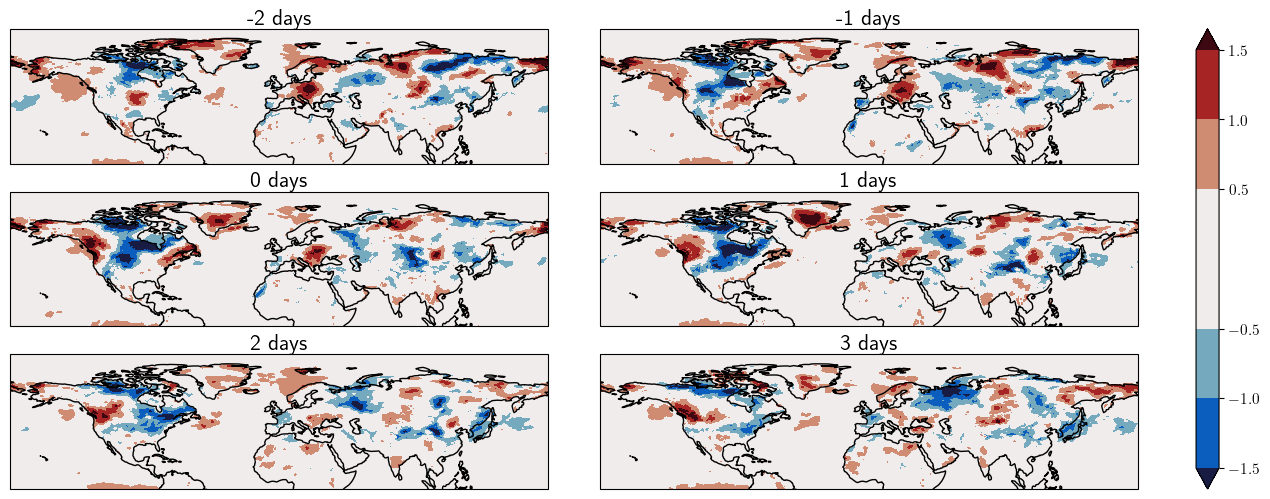

In [170]:
T_masked = mask_from_spells(
    da_T, spells_ts, spells_as_np, time_before=np.timedelta64(2, "D")
)
clu = Clusterplot(3, 2, get_region(da_T))
_ = clu.add_contourf(
    T_masked.mean("spell")[[0, 1, 2, 3, 4, 5]],
    levels=7,
    cmap=colormaps.balance,
    titles=T_masked.time_around_beg[[0, 1, 2, 3, 4, 5]].values.astype("timedelta64[D]"),
)

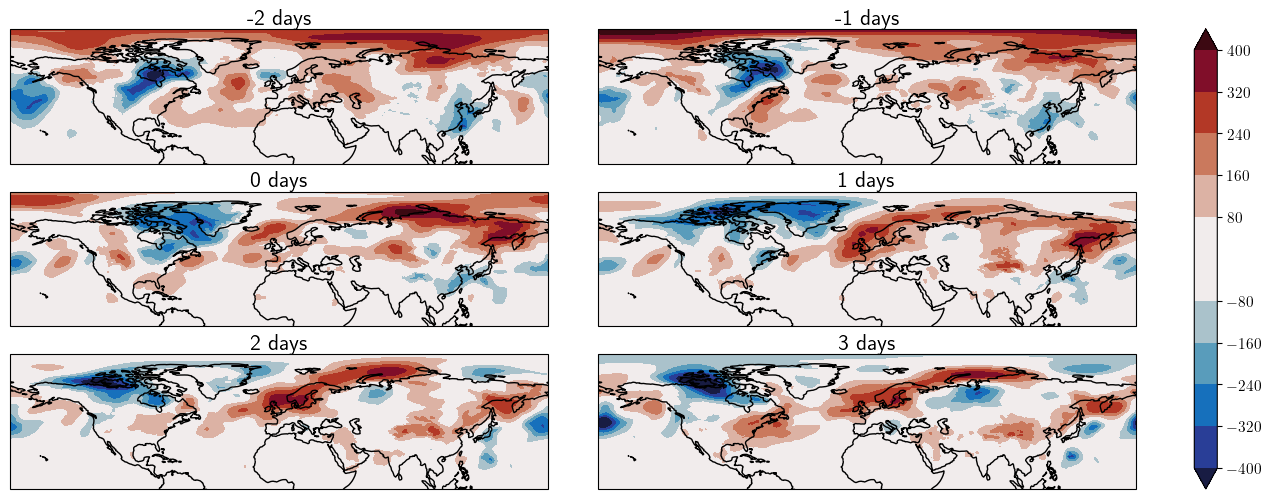

In [172]:
mslp_masked = mask_from_spells(
    da_mslp, spells_ts, spells_as_np, time_before=np.timedelta64(2, "D")
)
clu = Clusterplot(3, 2, get_region(da_mslp))
_ = clu.add_contourf(
    mslp_masked.mean("spell")[[0, 1, 2, 3, 4, 5]],
    levels=11,
    cmap=colormaps.balance,
    titles=mslp_masked.time_around_beg[[0, 1, 2, 3, 4, 5]].values.astype("timedelta64[D]"),
)

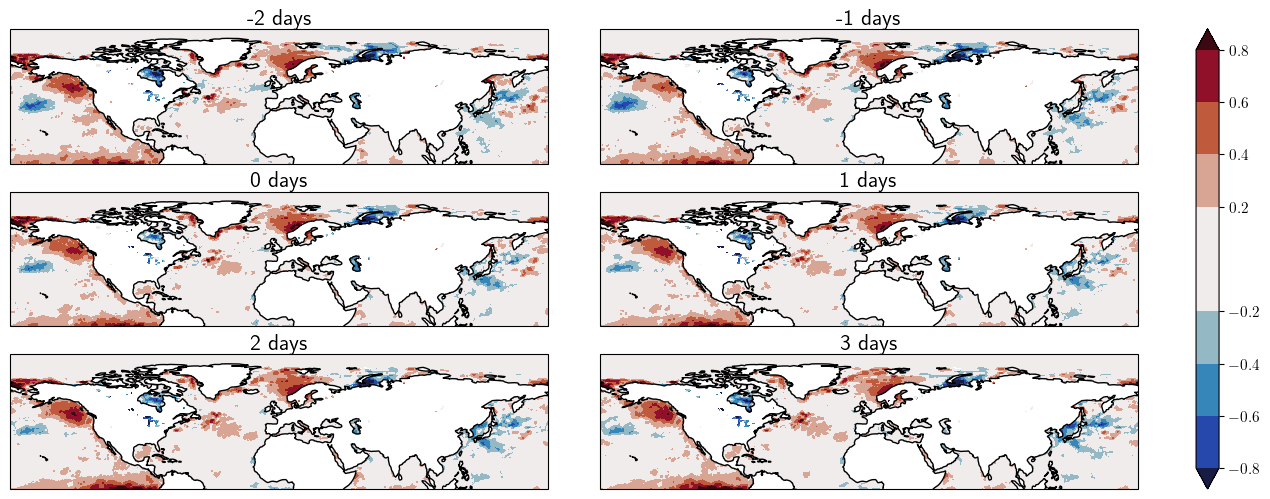

In [173]:
sst_masked = mask_from_spells(
    da_sst, spells_ts, spells_as_np, time_before=np.timedelta64(2, "D")
)
clu = Clusterplot(3, 2, get_region(da_sst))
_ = clu.add_contourf(
    sst_masked.mean("spell")[[0, 1, 2, 3, 4, 5]],
    levels=7,
    cmap=colormaps.balance,
    titles=sst_masked.time_around_beg[[0, 1, 2, 3, 4, 5]].values.astype("timedelta64[D]"),
)

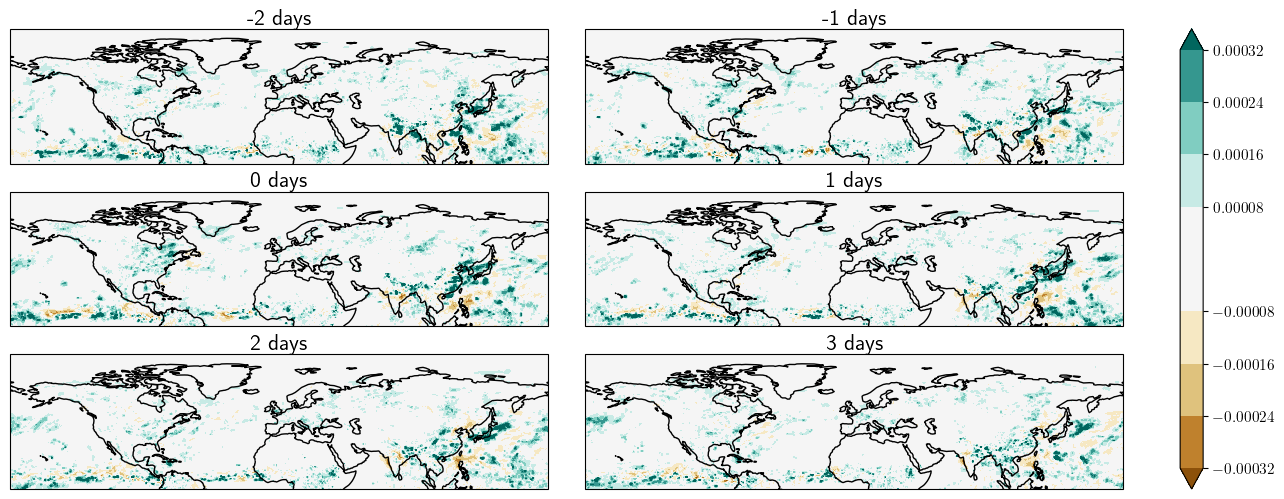

In [174]:
tp_masked = mask_from_spells(da_tp, spells_ts, spells_as_np, time_before=np.timedelta64(2, "D"))
clu = Clusterplot(3, 2, get_region(da_tp))
_ = clu.add_contourf(
    tp_masked.mean("spell")[[0, 1, 2, 3, 4, 5]],
    levels=7,
    cmap=colormaps.brbg,
    titles=tp_masked.time_around_beg[[0, 1, 2, 3, 4, 5]].values.astype("timedelta64[D]"),
)

In [175]:
all_spells_time = np.unique(np.concatenate(spells_ts))

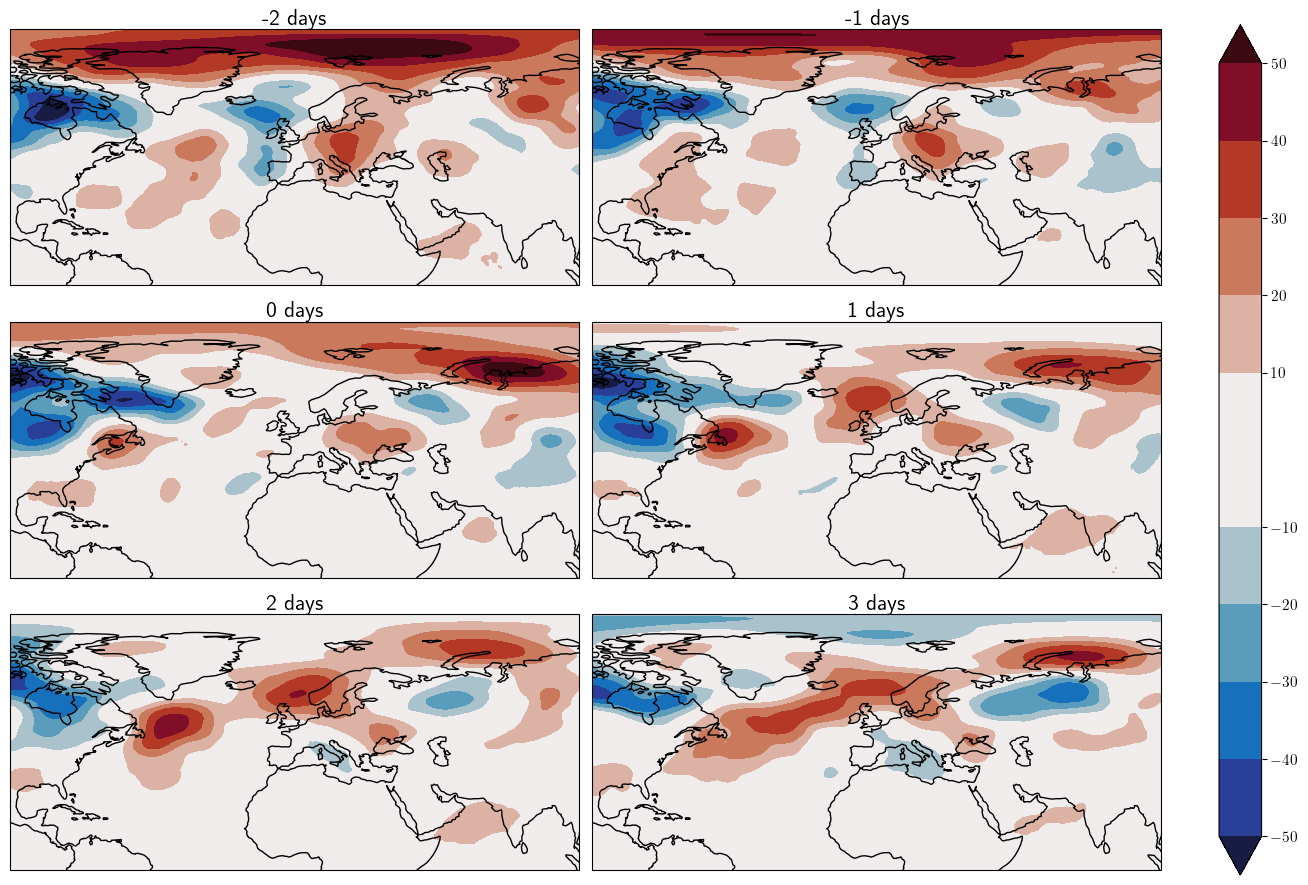

In [176]:
import scipy.constants as co
z_masked = mask_from_spells(_compute(da_z_dailymean.sel(time=all_spells_time)), spells_ts, spells_as_np, time_before=np.timedelta64(2, "D"))
clu = Clusterplot(3, 2, get_region(da_z))
_ = clu.add_contourf(
    z_masked.mean("spell")[[0, 1, 2, 3, 4, 5]] / co.g,
    levels=11,
    cmap=colormaps.balance,
    titles=z_masked.time_around_beg[[0, 1, 2, 3, 4, 5]].values.astype("timedelta64[D]"),
)

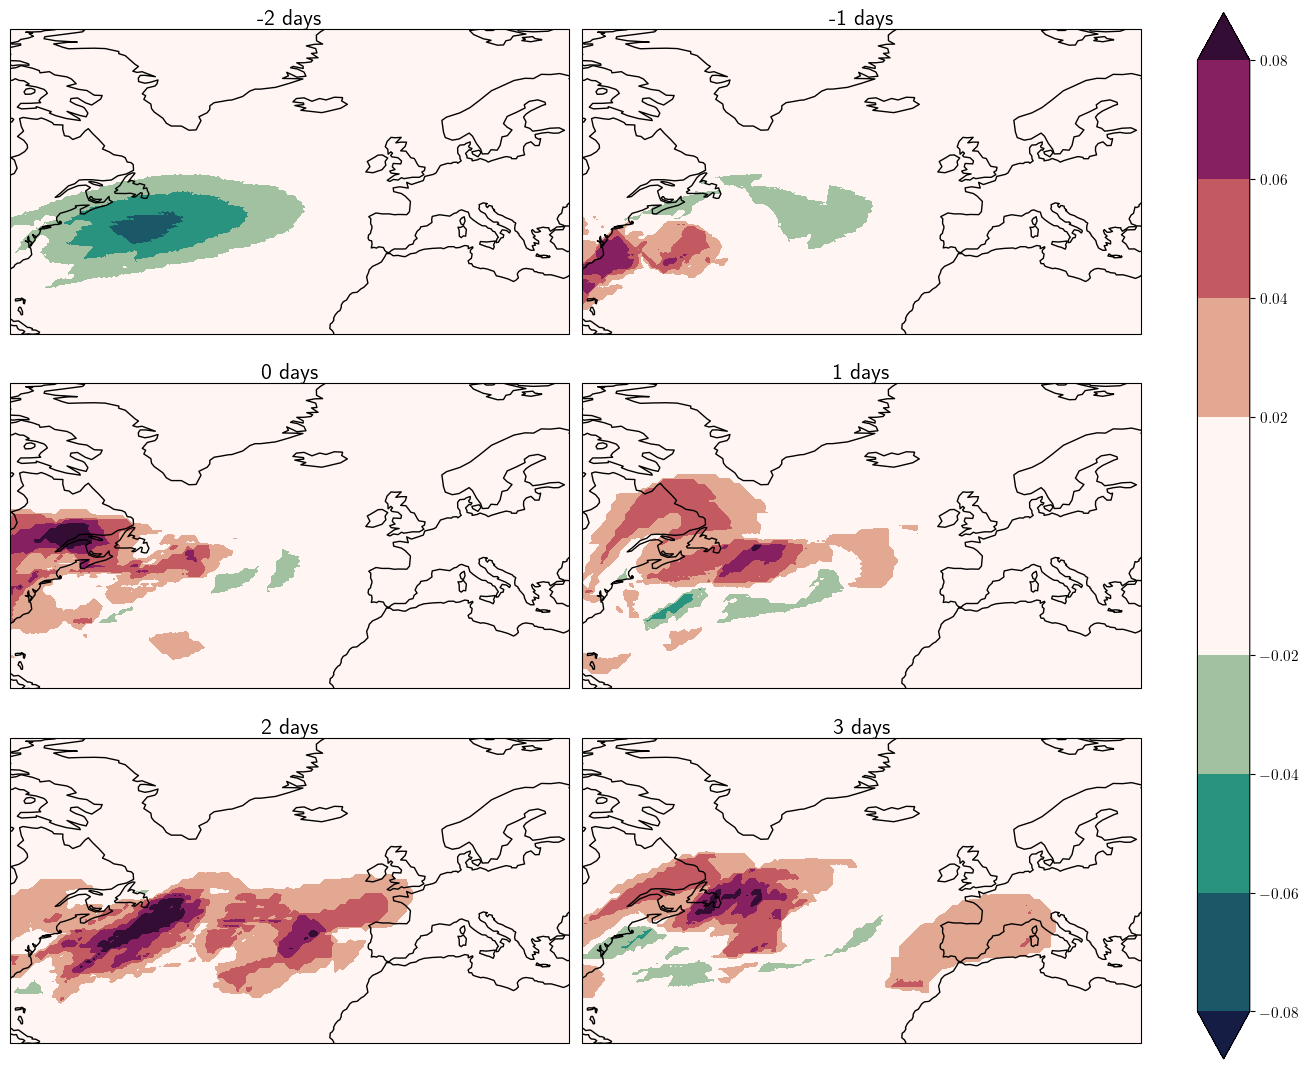

In [177]:
apvs_masked = mask_from_spells(_compute(da_pvs_dailymean.sel(type="anti", time=all_spells_time)), spells_ts, spells_as_np, time_before=np.timedelta64(2, "D"))
clu = Clusterplot(3, 2, get_region(da_pvs))
_ = clu.add_contourf(
    apvs_masked.mean("spell")[[0, 1, 2, 3, 4, 5]],
    levels=7,
    cmap=colormaps.curl,
    titles=apvs_masked.time_around_beg[[0, 1, 2, 3, 4, 5]].values.astype("timedelta64[D]"),
)

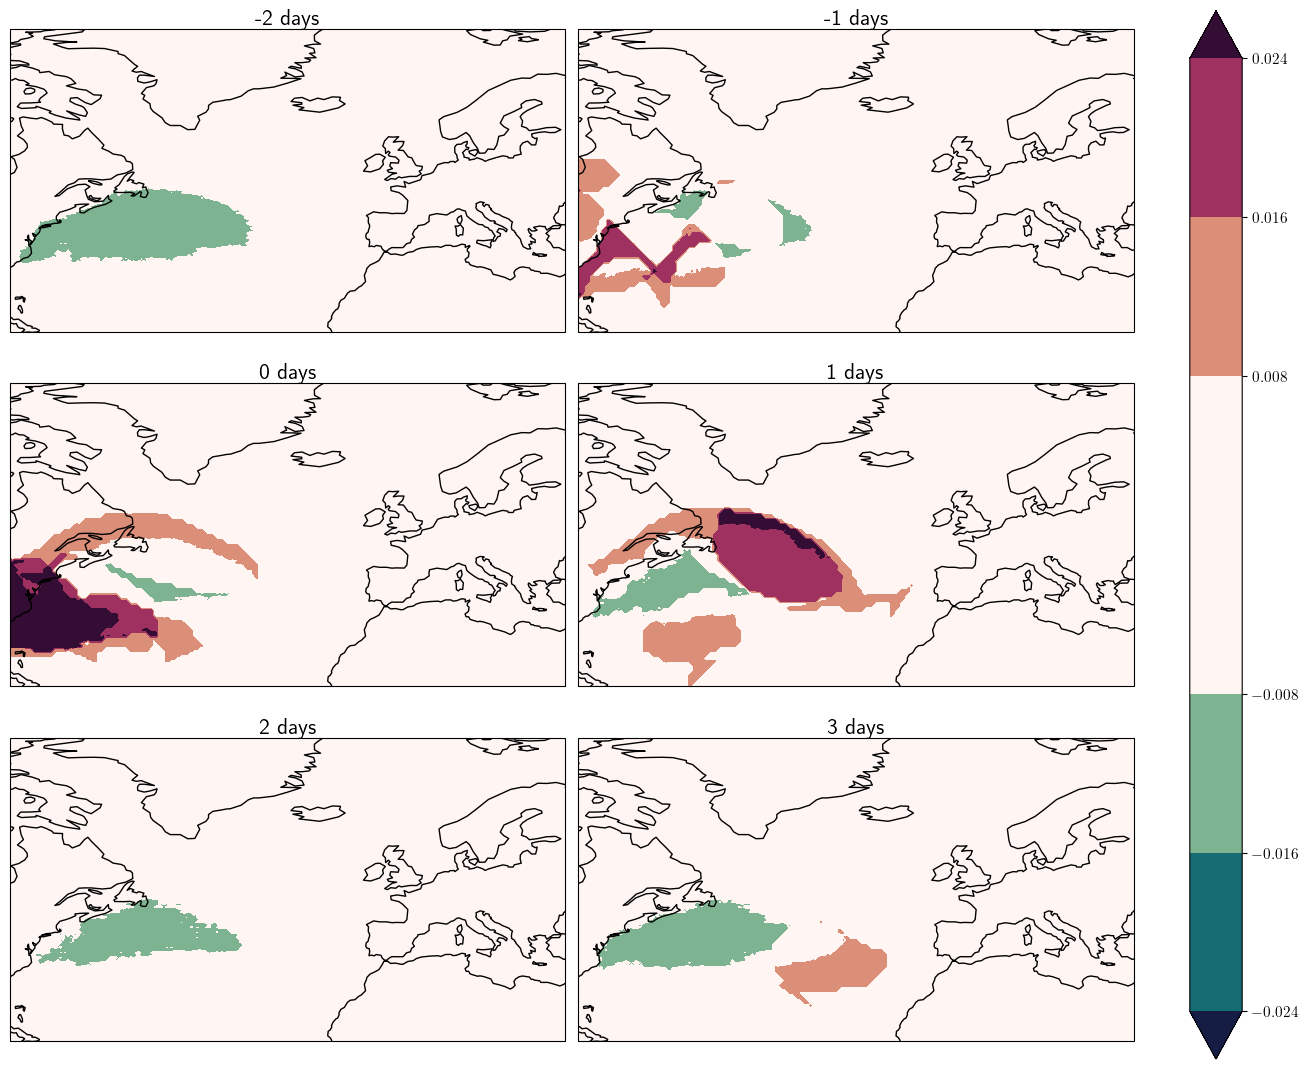

In [178]:
cpvs_masked = mask_from_spells(_compute(da_pvs_dailymean.sel(type="cycl", time=all_spells_time)), spells_ts, spells_as_np, time_before=np.timedelta64(2, "D"))
clu = Clusterplot(3, 2, get_region(da_pvs))
_ = clu.add_contourf(
    cpvs_masked.mean("spell")[[0, 1, 2, 3, 4, 5]],
    levels=7,
    cmap=colormaps.curl,
    titles=cpvs_masked.time_around_beg[[0, 1, 2, 3, 4, 5]].values.astype("timedelta64[D]"),
)

In [9]:
def get_persistent_spell_times(props_as_df, metric: Literal["persistence", "com_speed"], jet: Literal["EDJ", "STJ"], season: list | str | None = None):
    props_as_df = extract_season_from_df(props_as_df, season)
    times = props_as_df["time"].unique()
    onejet = props_as_df.filter(pl.col("jet") == jet)
    out = onejet[metric]
    if metric == "com_speed":
        out = (out < out.quantile(0.2))
    else:
        out = (out > out.quantile(0.8))
    out = out.rle().struct.unnest()
    out = out.with_columns(start=pl.lit(0).append(pl.col("len").cum_sum().slice(0, pl.col("len").len() - 1)))
    nt_before, nt_after = 8, 8
    out = out.filter(pl.col("value"), pl.col("len") >= 4).with_columns(
        range=pl.int_ranges(pl.col("start") - nt_before, pl.col("start") + pl.col("len") + nt_after),
        relative_index=pl.int_ranges(-nt_before, pl.col("len") + nt_after),
    )
    out = out.with_row_index("persistent_spell").explode(["range", "relative_index"])
    out = out.with_columns(time=times[out["range"]])
    return out

In [11]:
spells = get_persistent_spell_times(props_as_df, "com_speed", "EDJ", "JJA")

In [ ]:
spells

In [ ]:
spells.group_by("persistent_spell").first()["len"].top_k(10)

In [6]:
def get_persistent_jet_spells(props_as_df, metric: Literal["persistence", "com_speed"], jet: Literal["EDJ", "STJ"], season: list | str | None = None):
    props_as_df = extract_season_from_df(props_as_df, season)
    times = props_as_df["time"].unique()
    onejet = props_as_df.filter(pl.col("jet") == jet)
    out = onejet[metric] 
    if metric == "com_speed":
        out = (out < out.quantile(0.2))
    else:
        out = (out > out.quantile(0.8))
    out = out.rle().struct.unnest()
    out = out.with_columns(start=pl.lit(0).append(pl.col("len").cum_sum().slice(0, pl.col("len").len() - 1)))
    nt_before, nt_after = 8, 8
    out = out.filter(pl.col("value"), pl.col("len") >= 4).with_columns(
        range=pl.int_ranges(pl.col("start") - nt_before, pl.col("start") + pl.col("len") + nt_after),
        relative_index=pl.int_ranges(-nt_before, pl.col("len") + nt_after),
    )
    out = out.with_row_index("persistent_spell").explode(["range", "relative_index"])
    out = out.with_columns(time=times[out["range"]])
    out = out.join(props_as_df, on="time").drop("value", "start", "range")
    return out

In [4]:
persistent_spells = get_persistent_jet_spells(props_as_df, "persistence", "EDJ", "JJA")
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "int", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = persistent_spells.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])

In [5]:
persistent_spells = get_persistent_jet_spells(props_as_df, "com_speed", "EDJ", "JJA")
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "int", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = persistent_spells.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])

In [6]:
persistent_spells = get_persistent_jet_spells(props_as_df, "persistence", "STJ", "JJA")
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "int", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = persistent_spells.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])

In [7]:
persistent_spells = get_persistent_jet_spells(props_as_df, "com_speed", "STJ", "JJA")
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "int", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = persistent_spells.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])

In [9]:
metric = "euclidean"
nx = 6
ny = 4
exp_s = Experiment(DataHandler.from_specs("ERA5", "plev", "s", "6H", "all", "JJA", -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=True))

ds_center_path = exp_s.path.joinpath(f"som_{nx}_{ny}_pbc_{metric}_center.nc")
if not ds_center_path.is_file():
    ds = exp.ds
    ds = ds.sel(time=ds.time.dt.season=="JJA")
net, centers, labels = exp_s.som_cluster(
    nx,
    ny,
    activation_distance=metric,
    return_type=RAW_REALSPACE,
    force=False,
    sigma=2,
    train_kwargs=dict(num_epochs=20),
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
if not ds_center_path.is_file():
    ds_center = labels_to_centers(labels, ds)
    ds_center.to_netcdf(ds_center_path)
else:
    ds_center = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_s.da.time, "cluster": np.arange(net.n_nodes)})

In [10]:
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "int", "com_speed", "persistence", "waviness1", "wavinessR16"]
times = props_as_df["time"].unique()
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
labels_df = pl.from_pandas(labels.to_dataframe().reset_index())
labels_time = labels_df["time"].unique(maintain_order=True)
persistent_spells = labels_df["labels"].rle().struct.unnest()
persistent_spells = persistent_spells.filter(pl.col("len") >= 8)
persistent_spells = persistent_spells.with_columns(start=pl.lit(0).append(pl.col("len").cum_sum().slice(0, pl.col("len").len() - 1)))
nt_before, nt_after = 8, 0
persistent_spells = persistent_spells.filter(pl.col("len") >= 4).with_columns(
    range=pl.int_ranges(pl.col("start") - nt_before, pl.col("start") + pl.col("len") + nt_after),
    relative_index=pl.int_ranges(-nt_before, pl.col("len") + nt_after),
)
persistent_spells = persistent_spells.with_row_index("persistent_spell").explode(["range", "relative_index"])
persistent_spells = persistent_spells.with_columns(time=times[persistent_spells["range"]])
persistent_spells = persistent_spells.join(props_as_df, on="time").drop("start", "range")

In [16]:
mean_ps = persistent_spells.group_by(["value", "relative_index", "jet"]).agg(**aggs).sort(["value", "relative_index", "jet"])
props_on_som = labels_df.join(props_as_df.cast({"time": labels_df["time"].dtype}), on="time")
props_on_som = props_on_som.drop("time").group_by(["labels", "jet"], maintain_order=True).mean().sort(["labels", "jet"])

In [17]:
x = mean_ps["relative_index"].unique()
data_var = "mean_s"
many_colors = colormaps.cet_g_bw(np.linspace(0, 1, 256))
fig, axes = honeycomb_panel(4, 6, ratio = 0.5)
axes = axes.ravel()
for value in range(24):
    ax = axes[value]
    for j, jet in enumerate(["STJ", "EDJ"]):
        to_plot = mean_ps.filter(pl.col("value") == value, pl.col("jet") == jet)
        x_ = x[:len(to_plot)]
        ax.plot(x_, to_plot[data_var], color=COLORS[2 - j])
        this_mean = props_on_som.filter(pl.col("labels") == value, pl.col("jet") == jet)
        if len(x_) == 0:
            continue
        ax.plot([x_[0], x_[-1]], [this_mean[data_var], this_mean[data_var]], ls="dashed", color=COLORS[2 - j])
    title = value + 1
    try:
        title = f"{title}, {to_plot['alive'][0]}"
    except IndexError:
        pass
    ax.set_title(title)

In [18]:
mean_ps = persistent_spells.group_by(["relative_index", "jet"]).agg(**aggs).sort(["relative_index", "jet"])

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])